#Ans 1:

A suitable diagonal matrix $D^k$ cannot be chosen for this situation since the given function cannot be written in the form of $x^TAx + b^Tx + c$ where $A$ is a 2x2 symmetric matrix.

In [1]:
import numpy as np
from scipy.linalg import sqrtm
import matplotlib.pyplot as plt

In [2]:
def evalf(x):
  assert type(x) is np.ndarray and len(x) == 2
  return (512*(x[1]-x[0]**2)**2 + (4-x[0])**2)

In [3]:
def evalg(x):
  assert type(x) is np.ndarray and len(x) == 2
  return np.array([-2048*x[0]*(x[1]-x[0]**2)+2*x[0]-8, 1024*(x[1]-x[0]**2)])

In [4]:
def evalh(x):
  return np.array([[-2048*x[1]+6144*x[0]**2+2,-2048*x[0]],[-2048*x[0],1024]])

In [5]:
def compute_dk(hes):
  return np.linalg.inv(hes)

In [6]:
def compute_steplength_backtracking(x, gradf, alpha_start, rho, gamma):
  assert type(x) is np.ndarray and len(x) == 2
  assert type(gradf) is np.ndarray and len(gradf) == 2
  
  alpha = alpha_start

  while evalf(x+alpha*-gradf) > evalf(x) + gamma*alpha*np.matmul(gradf.transpose(),-gradf):
    alpha = rho*alpha

  return alpha

In [7]:
def compute_steplength_backtracking_scaled_direction(x, gradf, alpha_start, rho, gamma, d_k):
  assert type(x) is np.ndarray and len(x) == 2
  assert type(gradf) is np.ndarray and len(gradf) == 2
  
  alpha = alpha_start

  while evalf(x+alpha*np.matmul(d_k,(-gradf))) > evalf(x) + gamma*alpha*np.matmul(gradf.transpose(),np.matmul(d_k,-gradf)):
    alpha = rho*alpha

  return alpha

In [8]:
BACKTRACKING_LINE_SEARCH = 1
BACKTRACKING_LINE_SEARCH_WITH_SCALING = 2

In [9]:
def find_minimizer(start_x, tol, line_search_type, *args):
  #Input: start_x is a numpy array of size 2, tol denotes the tolerance and is a positive float value
  assert type(start_x) is np.ndarray and len(start_x) == 2 #do not allow arbitrary arguments 
  assert type(tol) is float and tol>=0 
  # construct a suitable A matrix for the quadratic function
  x = start_x
  g_x = evalg(x)

  alpha_start = args[0]
  rho = args[1]
  gamma = args[2]
  hes_x = evalh(x)
  condition_no = []

  #initialization for backtracking line search
  if(line_search_type == BACKTRACKING_LINE_SEARCH_WITH_SCALING):
    d_k = compute_dk(hes_x)

  k = 0
  #print('iter:',k, ' x:', x, ' f(x):', evalf(x), ' grad at x:', g_x, ' gradient norm:', np.linalg.norm(g_x))

  while (np.linalg.norm(g_x) > tol): #continue as long as the norm of gradient is not close to zero upto a tolerance tol
  
    if line_search_type == BACKTRACKING_LINE_SEARCH:
      step_length = compute_steplength_backtracking(x,g_x, alpha_start,rho, gamma)
      x = np.subtract(x, np.multiply(step_length,g_x)) #update x = x - step_length*g_x
      k += 1 #increment iteration
      g_x = evalg(x) #call the new function you wrote to compute the steplength
      hes_x = evalh(x)
      condition_no.append(max(np.linalg.eig(hes_x)[0])/min(np.linalg.eig(hes_x)[0]))
      #raise ValueError('EXACT LINE SEARCH NOT YET IMPLEMENTED')
    elif line_search_type == BACKTRACKING_LINE_SEARCH_WITH_SCALING:
      step_length = compute_steplength_backtracking_scaled_direction(x,g_x, alpha_start,rho, gamma, d_k)
      x = np.subtract(x, np.multiply(step_length,np.matmul(d_k,g_x))) #update x = x - step_length*g_x
      k += 1 #increment iteration
      g_x = evalg(x) #compute gradient at new point
      hes_x = evalh(x)
      d_k = compute_dk(hes_x) #call the new function you wrote to compute the steplength
      condition_no.append(max(np.linalg.eig(np.matmul(np.matmul(sqrtm(d_k),hes_x),sqrtm(d_k)))[0])/min(np.linalg.eig(np.matmul(np.matmul(sqrtm(d_k),hes_x),sqrtm(d_k)))[0]))
      #raise ValueError('BACKTRACKING LINE SEARCH NOT YET IMPLEMENTED')
    else:  
      raise ValueError('Line search type unknown. Please check!')
    
    #print('iter:',k, ' x:', x, ' f(x):', evalf(x), ' grad at x:', g_x, ' gradient norm:', np.linalg.norm(g_x))
  return x,k,evalf(x),condition_no

#Ans 3:

The Q matrix can be the $M^T\nabla_{\mathbf{x}} f(\mathbf{x})M$ where $M=D^{1/2}$

In [10]:
my_start_x = np.array([8.,8.])
my_tol = 1e-5

In [11]:
x_ns,k_ns,f_ns,cond_ns = find_minimizer(my_start_x, my_tol, BACKTRACKING_LINE_SEARCH,1.0,0.5,0.5)

In [12]:
x_s,k_s,f_s,cond_s = find_minimizer(my_start_x, my_tol, BACKTRACKING_LINE_SEARCH_WITH_SCALING,1.0,0.5,0.5)

In [13]:
print(x_ns,k_ns,f_ns)

[ 3.99995977 15.99967817] 902389 1.6183088090612175e-09


In [14]:
print(x_s,k_s,f_s)

[ 4. 16.] 48 2.356430075812841e-25


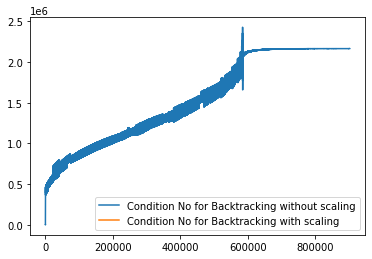

In [15]:
plt.plot(cond_ns, label = 'Condition No for Backtracking without scaling')
plt.plot(cond_s, label = 'Condition No for Backtracking with scaling')
plt.legend()
plt.show()

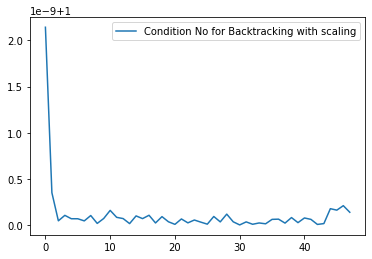

In [16]:
plt.plot(cond_s, label = 'Condition No for Backtracking with scaling')
plt.legend()
plt.show()

#Ans 4:

We can observe that for backtracking without scaling even after taking more than 90000 iterations the solution is not exact whereas for backtracking with scaling just after 48 iterations we get the solution.

(Since the plot for backtracking with scaling was not visible in the combined plot, I have made an individual plot for it.)

We can observe that for backtracking with scaling, condition no. always lingers around 1.

As for backtracking without scaling, condition no. increases rapidly as iterations increase.